### Visualizing the distribution of the observations

### Load the required libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='BSBSSSSB'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()
print STAT
print STAT_Descriptions
#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index

df=sqlContext.read.parquet(filename)
print df.count()
df.show(5)

Populating the interactive namespace from numpy and matplotlib
keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']
{'TMIN': {'std': 83.758919032662803, 'UnDef': array([15,  0,  0,  0,  0,  4,  0,  0,  8,  0,  0,  0,  0,  0,  4,  0,  4,
        0,  0]), 'E': array([  58781.,   36163.,   46753.,   37170.,   31686.,   33826.,
         44575.,   34754.,   27097.,   28988.,   27283.,   26267.,
         34255.,   24547.,   33927.,   22084.,   24084.,   46920.,
         44610.,   34861.,   38758.,   45315.,   53521.,   54014.,
         42532.,   41480.,   45562.,   33758.,   34496.,   48994.,
         39587.,   41004.,   53477.,   45831.,   38269.,   35949.,
         52083.,   44839.,   29577.,   44311.,   42258.,   41837.,
         26174.,   40608.,   48282.,   65830.,   70889.,   61618.,
         63277.,   67793.,   70820.,   71881.,   81993.,   82009.,
         80433.,   72162.,   67149.,   77253.,   83782.,   88101.,
         86675.,   97139.,   93430.,   97447.,  100965.,   

12127
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    196.9| 32.3178| -84.5203|       TMAX|USC00091372|    23|[A0 57 00 58 00 5...|1959.0|BSBSSSSB|
|    196.9| 32.3178| -84.5203|       TMAX|USC00091372|    15|[30 55 30 54 B8 5...|1960.0|BSBSSSSB|
|    196.9| 32.3178| -84.5203|       TMAX|USC00091372|    16|[38 59 A0 57 90 5...|1961.0|BSBSSSSB|
|    196.9| 32.3178| -84.5203|       TMAX|USC00091372|    29|[28 58 F0 56 B0 5...|1963.0|BSBSSSSB|
|    196.9| 32.3178| -84.5203|       TMAX|USC00091372|     3|[00 46 F0 56 90 5...|1964.0|BSBSSSSB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 5 rows



### Select data for a particular station and measurement type

In [2]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('PRCP','USC00091372')
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(47)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T=np.vstack(rows)
T=T/10.  # scaling to make the temperature be in centingrates
shape(T)
print T

SELECT * FROM weather
	WHERE measurement='PRCP' and station='USC00091372'
47 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    196.9| 32.3178| -84.5203|       PRCP|USC00091372|     2|[00 00 00 00 00 0...|1949.0|BSBSSSSB|
|    196.9| 32.3178| -84.5203|       PRCP|USC00091372|     2|[00 00 00 00 00 0...|1950.0|BSBSSSSB|
|    196.9| 32.3178| -84.5203|       PRCP|USC00091372|    20|[00 7E 00 7E 00 7...|1957.0|BSBSSSSB|
|    196.9| 32.3178| -84.5203|       PRCP|USC00091372|     1|[00 42 00 00 00 0...|1958.0|BSBSSSSB|
|    196.9| 32.3178| -84.5203|       PRCP|USC00091372|     0|[20 5A 00 49 B0 5...|1959.0|BSBSSSSB|
|    196.9| 32.3178| -84.5203|       PRCP|USC00091372|     0|[C0 4D 80 4C 70 5...|1960.0|BSBSSSSB|
|    196.9| 32.3178| -84.52

### Script for plotting yearly plots

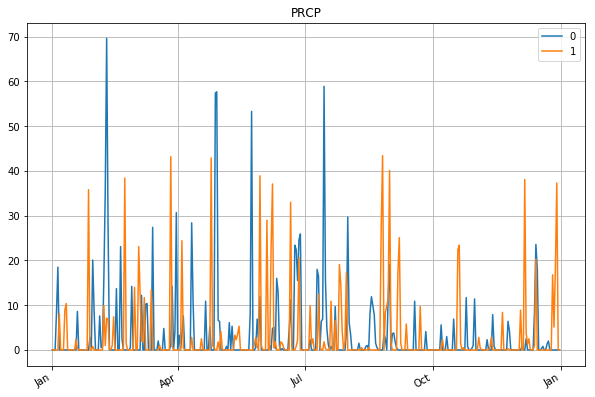

In [3]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(T[:2,:].transpose(),fig,ax,title='PRCP')
#title('A sample of graphs');

### Distribution of missing observations
The distribution of missing observations is not uniform throughout the year. We visualize it below.

In [4]:
def plot_pair(pair,func):
    j=0
    fig,X=subplots(1,2,figsize=(16,6))
    axes=X.reshape(2)
    for m in pair:
        axis = axes[j]
        j+=1
        func(m,fig,axis)
        
def plot_valid(m,fig,axis):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title='valid-counts '+m)
    

/Users/yuchenfeng/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


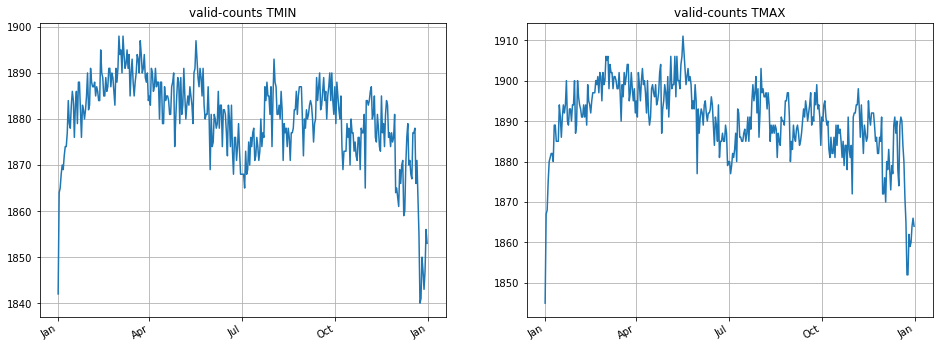

In [5]:
plot_pair(['TMIN','TMAX'],plot_valid)

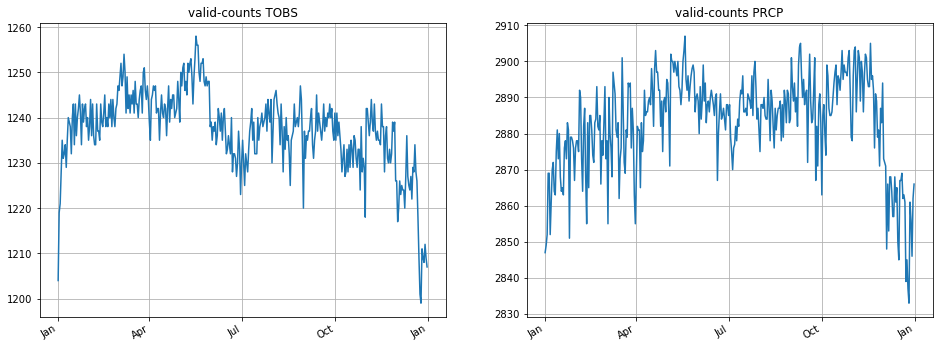

In [6]:
plot_pair(['TOBS','PRCP'],plot_valid)

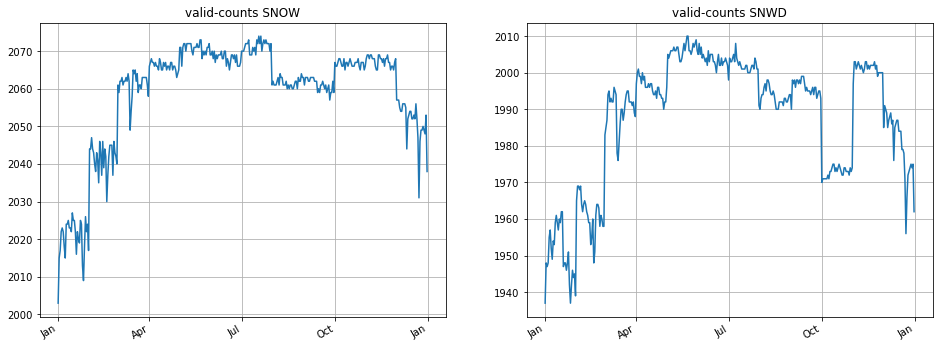

In [7]:
plot_pair(['SNOW', 'SNWD'],plot_valid)

### Plots of mean and std of observations

In [20]:
def plot_mean_std(m,fig,axis):
    mean=STAT[m]['Mean']
    std=np.sqrt(STAT[m]['Var'])
    graphs=np.vstack([(mean-std)/10.0,mean/10.0,(mean+std)/10.0]).transpose()
    if m == 'TMIN' or m == 'TMAX':
        axis.set_ylabel('Degress Celsius')
    elif m == 'TOBS' or m =='PRCP':
        axis.set_ylabel('millimeter')
    
    YP.plot(graphs,fig,axis,title='Mean+-std   '+m,labels = ['mean-std','mean','mean+std'])

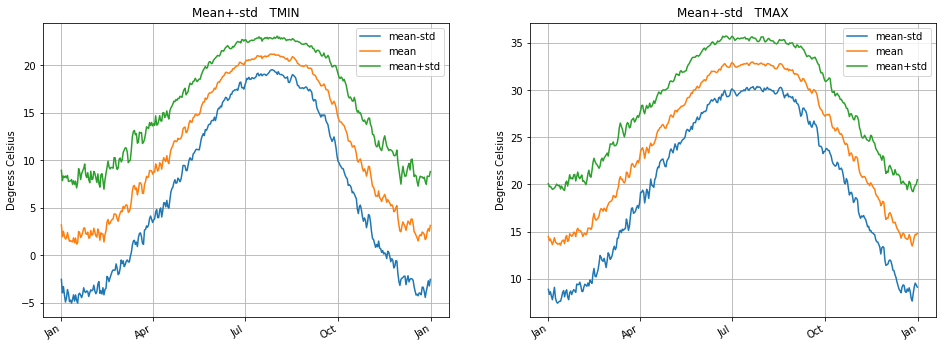

In [21]:
plot_pair(['TMIN','TMAX'],plot_mean_std)

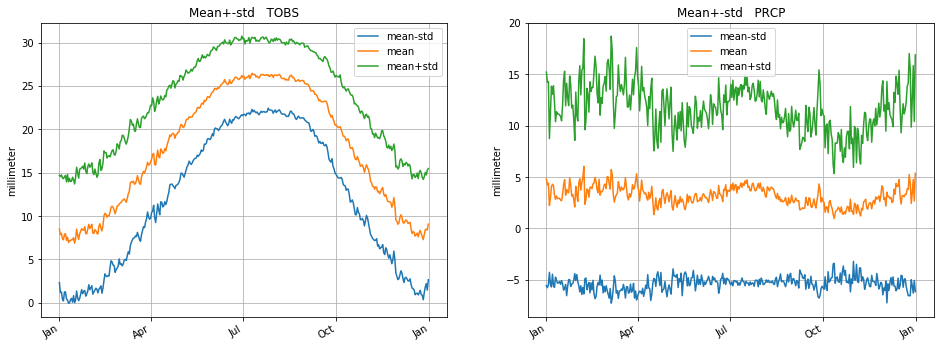

In [22]:
plot_pair(['TOBS','PRCP'],plot_mean_std)

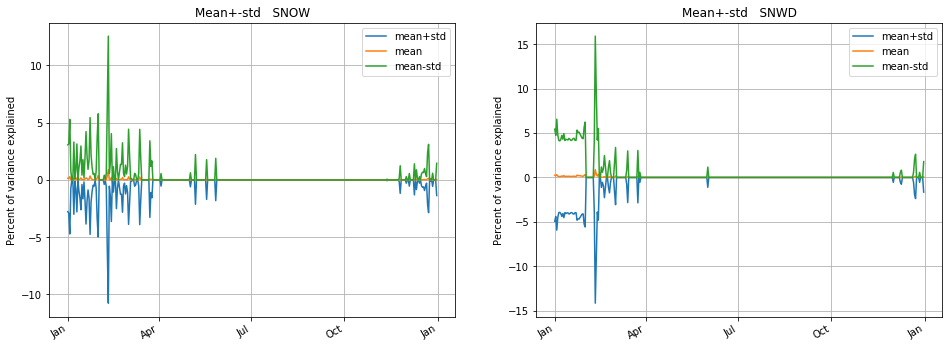

In [11]:
plot_pair(['SNOW', 'SNWD'],plot_mean_std)

In [25]:
t = STAT['PRCP']['Mean']
print sum(t)/3650.0

3.18783802988


### plotting top 3 eigenvectors

In [16]:
def plot_eigen(m,fig,axis):
    EV=STAT[m]['eigvec']
    YP.plot(EV[:,:3],fig,axis,title='Top Eigenvectors '+m)

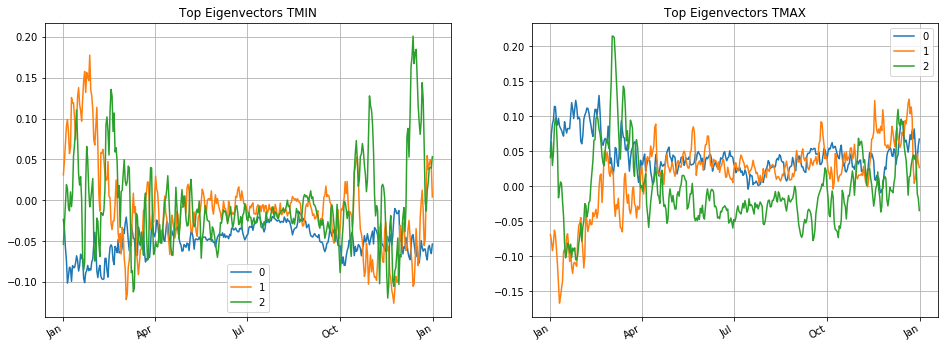

In [17]:
plot_pair(['TMIN','TMAX'],plot_eigen)

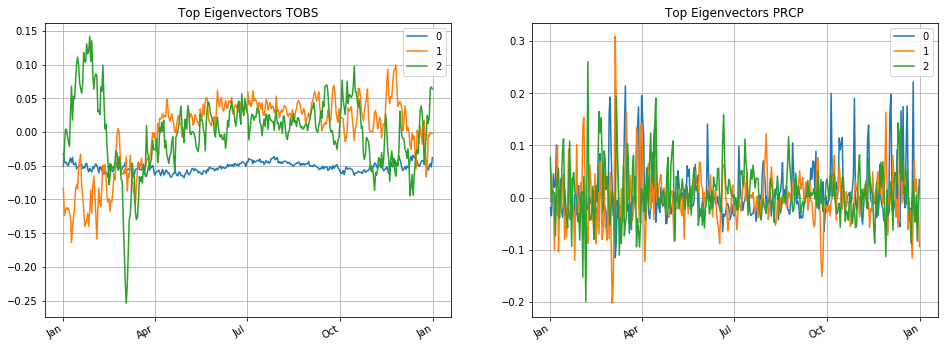

In [18]:
plot_pair(['TOBS','PRCP'],plot_eigen)

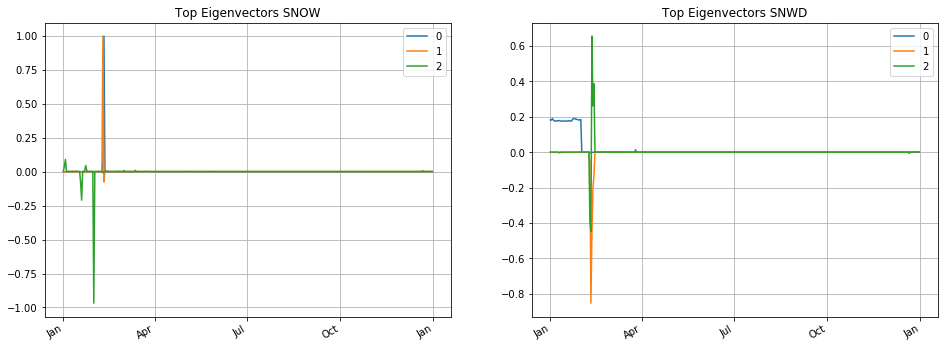

In [19]:
plot_pair(['SNOW', 'SNWD'],plot_eigen)

### Script for plotting percentage of variance explained

In [26]:
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=5
    plot(([0,]+list(cumsum(EV[:k])))/sum(EV))
    print EV[0] / sum(EV)
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()
    

0.0837541153036
0.388346336134
0.0598854683094


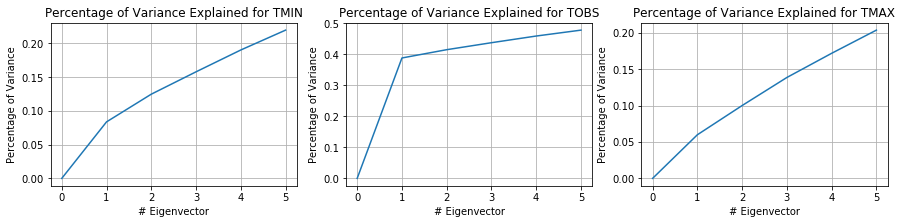

In [27]:
f=plt.figure(figsize=(15,3))
j=1
for m in ['TMIN', 'TOBS', 'TMAX']: #,
    pltVarExplained(j)
    j+=1

0.277719003153
0.484227630315
0.0169975356099


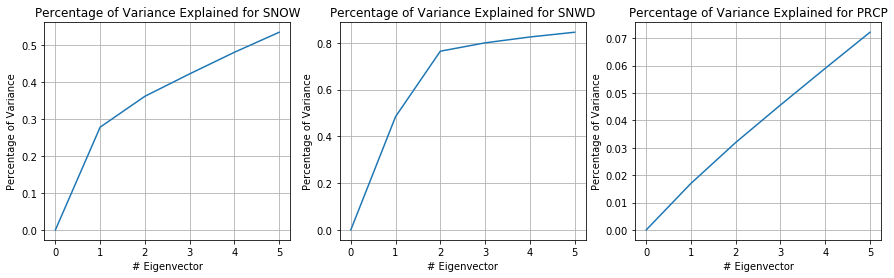

In [28]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW', 'SNWD', 'PRCP']:
    pltVarExplained(j)
    j+=1 

In [19]:
#sc.stop()